# Introduction to Kalman Filters

This notebook is inspired by the book: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/02-Discrete-Bayes.ipynb that I used to demonstrate my examples.

In my Kalman Filter course, we'll learn how to use Kalman Filters to track objects like vehicles, bounding boxes, or others.
First, we need to understand intuitions and probabilities; I found this notebook to emphasize my ideas.

I don't give this notebook because my example is different and I didn't want the students to be troubled. I used it to code the functions and explain how it works.

Here's what we'll do:
1.  Learn to visualize a bar plot
2.  Move our belief with predictions
3.  Use sensors and update our belief

Let's start by building an intuition <p>

![alt text](https://github.com/Jeremy26/kalman_filters_course/blob/master/img/speedy.png)

![](https://drive.google.com/uc?export=view&id=11p_cdeVhV_X0iqC0Ok0k6lVbdIc5c0UN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def bar_plot(pos, x=None, ylim=(0,1), title=None, c='#30a2da',
             **kwargs):
    """ plot the values in `pos` as a bar plot.
    **Parameters**
    pos : list-like
        list of values to plot as bars
    x : list-like, optional
         If provided, specifies the x value for each value in pos. If not
         provided, the first pos element is plotted at x == 0, the second
         at 1, etc.
    ylim : (lower, upper), default = (0,1)
        specifies the lower and upper limits for the y-axis
    title : str, optional
        If specified, provides a title for the plot
    c : color, default='#30a2da'
        Color for the bars
    **kwargs : keywords, optional
        extra keyword arguments passed to ax.bar()
    """

    ax = plt.gca()
    if x is None:
        x = np.arange(len(pos))
    ax.bar(x, pos, color=c, **kwargs)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(np.asarray(x), x)
    if title is not None:
        plt.title(title)

# Part 1 - Initial Filter

## Initial Belief

We have no idea where Speedy is at first.

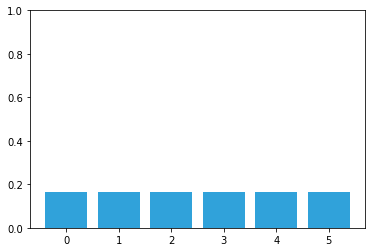

In [2]:
belief = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
bar_plot(belief)

## First Action
Speedy starts by activating its sensors and telling you it senses a wall
*   Sensing a Wall



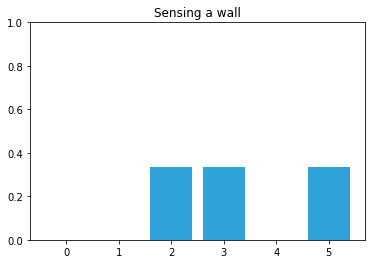

In [3]:
belief = np.array([0, 0, 1/3, 1/3, 0, 1/3])
bar_plot(belief, title= "Sensing a wall")

## Second Action
The second action Speedy makes is:

*   Move 1 to the right
*   Sense another wall



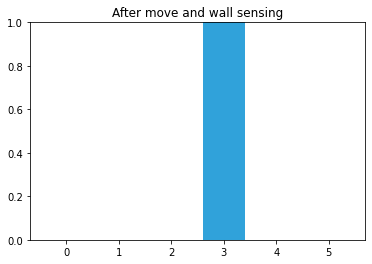

In [4]:
belief = np.array([0, 0, 0, 1, 0, 0])
bar_plot(belief, title= "After move and wall sensing")

# Part 2 - Adding the noise

Many functions we need are part of the filterpy library.
We can download it using 'pip install filterpy'

In [5]:
!pip install filterpy

     |████████████████████████████████| 184kB 2.7MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110451 sha256=21dbdea926f139ab1927ce096dc6da9c553e575d26df42d4b7d55fdb1bdb14d2
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


## First Action - Adding measurement noise

The sensors can be inaccurate, here is the graph with measurement noise.
We normalize it so the probabilities add up to 1.
Install filterpy to normalize it by uncommenting the first line

In [6]:
from filterpy.discrete_bayes import normalize, predict, update

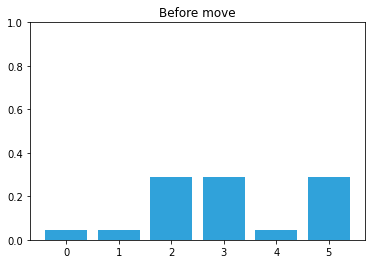

In [7]:
belief = np.array([0.05, 0.05, 1/3, 1/3, 0.05, 1/3])
belief = normalize(belief)

bar_plot(belief, title= "Before move")

## Second Action - Moving and Sensing again

Now, we repeat the second action:

*   Move 1 to the right
*   Sense a wall

### First, we'll move perfectly

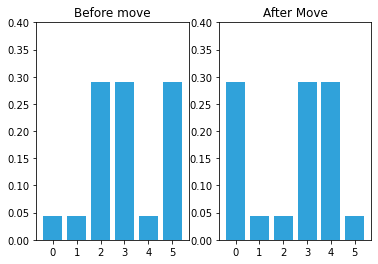

In [8]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result

plt.subplot(121)
bar_plot(belief,  title='Before move', ylim=(0, 0.4))
moved_belief = perfect_predict(belief, 1)
plt.subplot(122)
bar_plot(moved_belief,  title='After Move', ylim=(0,0.4))

### Let's do this at will

In [9]:
from ipywidgets import interact, IntSlider

belief = np.array([0.05, 0.05, 1/3, 1/3, 0.05, 1/3])
belief = normalize(belief)

perfect_beliefs = []

for _ in range(20):
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

### Now, let's move with noise. We actually have uncertainty, even when moving

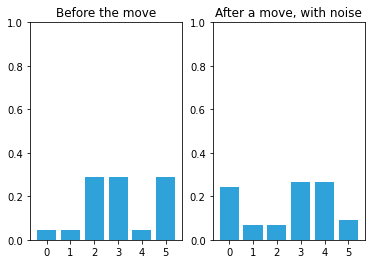

In [10]:
def predict_move(belief, move, p_under=.1, p_correct=.8, p_over=.1):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = np.array([0.05, 0.05, 1/3, 1/3, 0.05, 1/3])
belief = normalize(belief)
plt.subplot(121)
bar_plot(belief,  title='Before the move', ylim=(0, 1))

predicted = predict_move(belief, 1)
plt.subplot(122)
bar_plot(predicted,  title='After a move, with noise', ylim=(0, 1))

### Let's do this at will

In [11]:
belief = np.array([0, 0, 0, 1, 0, 0])
predict_beliefs = []

for i in range(100):
    belief = predict_move(belief, 1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    bar_plot(predict_beliefs[step-1])
    plt.title('Step {}'.format(step))

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.16667109 0.16667552 0.16667109 0.16666224 0.16665781 0.16666224]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

### We now know how to move with noise. The problem is we can't be sure that the miss is 1 maximum.

When we add noise, we always add noise 1 cell before, and 1 after the estimated position. What if there is more than 1 cell?

This is when we use Convolutions.

In FilterPy, the function 'predict' implements the Convolution idea I mention in the classroom.

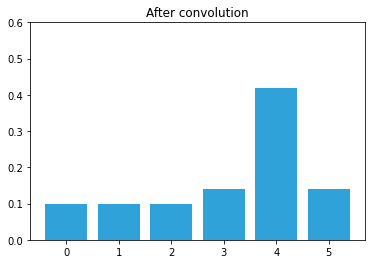

In [12]:
belief = [.1, .1, .1, .5, .1, .1]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
#plt.subplot(121)
#bar_plot(belief, ylim=(0,0.6), title='Before convolution')
#plt.subplot(122)
bar_plot(prior, ylim =(0,0.6), title= 'After convolution')

### Let's do this at will

In [13]:
belief = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
predict_beliefs = []

for i in range(100):
    belief= predict(belief, offset=1, kernel=[.1, .8, .1])
    predict_beliefs.append(belief)

print('Final Belief:', belief)

def show_prior(step):
    bar_plot(predict_beliefs[step-1])
    plt.title('Step {}'.format(step))

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.16667109 0.16667552 0.16667109 0.16666224 0.16665781 0.16666224]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

### We realize that 'moving' increases uncertainty. After every move, we'll need to sense to get new information.

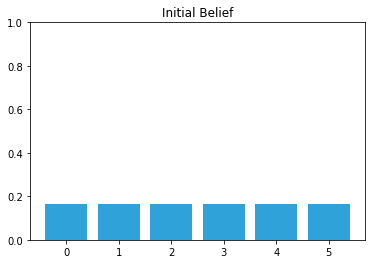

In [14]:
# Initial Belief is also called Prior.
prior = np.array(1/6 *np.ones(6))
bar_plot(prior, title='Initial Belief')

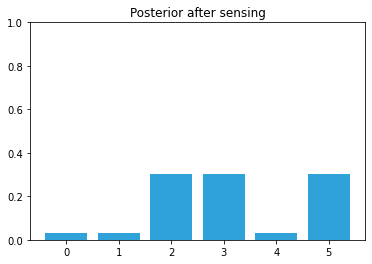

In [15]:
likelihood= normalize(([0.1,0.1,1,1,0.1,1]))

posterior = update(likelihood, prior)
bar_plot(posterior, title='Posterior after sensing')

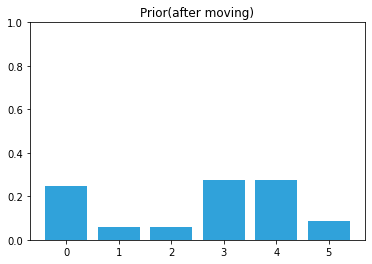

In [16]:
# Posterior becomes prior
# We move 1
prior = predict(posterior, offset=1, kernel=[.1, .8, .1])
bar_plot(prior, title='Prior(after moving)')

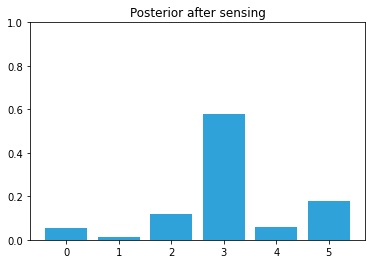

In [17]:
likelihood= normalize(([0.1,0.1,1,1,0.1,1]))

posterior = update(prior, likelihood)

bar_plot(posterior, title='Posterior after sensing')

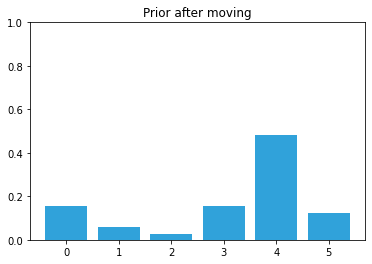

In [18]:
prior = predict(posterior, offset=1, kernel=[.1, .8, .1])
bar_plot(prior, title="Prior after moving")

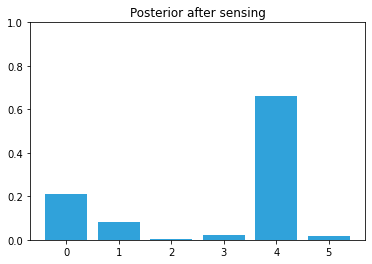

In [19]:
likelihood= normalize(([1,1,.1,.1,1,.1]))
#bar_plot(likelihood, title='Sensing a door')
posterior = update(prior, likelihood)

bar_plot(posterior, title="Posterior after sensing")

# Gaussians

We live in a continuous world. Let's see how gaussians can help us translate that idea.

Be sure you are familiar with the concepts of mean, expected value, variance, and standard deviation before you go on.

In [20]:
from filterpy.stats import plot_gaussian_pdf, gaussian

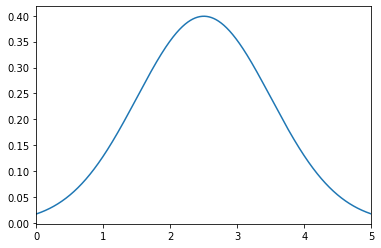

In [21]:
plot_gaussian_pdf(mean=2.5, variance = 1, xlim= (0,5), label = 'doors')

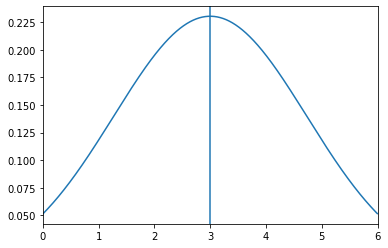

In [22]:
plot_gaussian_pdf(mean=3, variance = 3, mean_line=True , xlim = (0,6), label = 'doors')

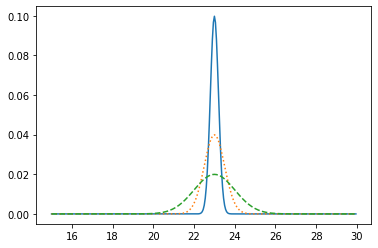

In [23]:
xs = np.arange(15, 30, 0.05)
plt.plot(xs, gaussian(xs, 23, 0.2**2), label='$\sigma^2=0.2^2$')
plt.plot(xs, gaussian(xs, 23, .5**2), label='$\sigma^2=0.5^2$', ls=':')
plt.plot(xs, gaussian(xs, 23, 1**2), label='$\sigma^2=1^2$', ls='--')

In [24]:
import math
from ipywidgets import interact, FloatSlider

def plt_g(mu,variance):
    plt.figure()
    xs = np.arange(2, 8, 0.01)
    ys = gaussian(xs, mu, variance)
    plt.plot(xs, ys)
    plt.ylim(0, 0.04)

interact(plt_g, mu=FloatSlider(value=5, min=3, max=7),
         variance=FloatSlider(value = .03, min=.01, max=1.));

interactive(children=(FloatSlider(value=5.0, description='mu', max=7.0, min=3.0), FloatSlider(value=0.03, desc…

## Predict using Gaussians

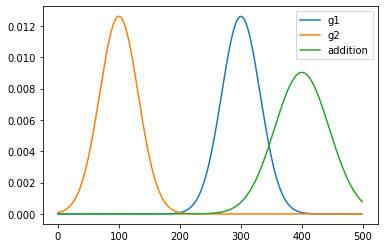

In [64]:
from filterpy.stats import add
mean1 = 3
var1 = .1
mean2 = 1
var2 = .1

g1 = gaussian(x, mean=mean1, var=var1)
g2 = gaussian(x, mean=mean2, var=var2)

def predict_gaussians(mean1, var1, mean2, var2):
    mean_sum, var_sum = add(mean1,var1, mean2, var2) # element-wise multiplication
    g = gaussian(x, mean=mean_sum, var=var_sum)
    return g
    
g = predict_gaussians(mean1, var1, mean2, var2)

plt.plot(g1, label ='g1')
plt.plot(g2, label='g2')
plt.plot (g, label= 'addition')
plt.legend();

## Update using Gaussians

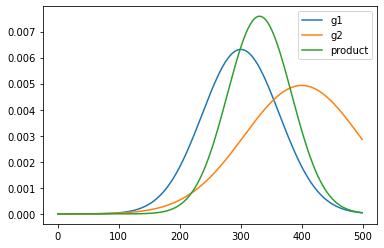

In [70]:
mean1 = 3
var1 = .4
mean2 = 4
var2 = .9

g1 = gaussian(x, mean=mean1, var=var1)
g2 = gaussian(x, mean=mean2, var=var2)

def update_gaussians(mean1, var1, mean2, var2):
    g = g1 * g2  # element-wise multiplication
    g = g / sum(g)  # normalize
    return g

g = update_gaussians(mean1, var2, mean2, var2)
plt.plot(g1, label ='g1')
plt.plot(g2, label='g2')
plt.plot (g, label= 'product')
plt.legend();